In [1]:
import json
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from math import radians, cos, sin, asin, sqrt




# I. Load the data & some insights

In [2]:
# We load the 3 datasets 
df_business = pd.read_csv('./data/df_business.csv')
df_reviews = pd.read_csv('./data/df_reviews.csv')
df_users = pd.read_csv('./data/df_user.csv')

In [3]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)
df_user = df_users.drop('friends', axis=1)

For reading purposes, the 3 datasets have the following form

In [26]:
df_business.head(3)

,business_id,state,latitude,longitude,categories,stars,state,Entertainment,Merchant,Education,...,Legal,RealEstate,Construction,Manufacturing,Health,Food,Home,Miscellaneous,BusinessSupport,PersonalCare
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"[Active Life, Gun/Rifle Ranges, Guns & Ammo, S...",3.5,NC,True,True,False,...,False,False,False,False,False,False,False,False,False,True
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"[Health & Medical, Fitness & Instruction, Yoga...",5.0,AZ,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,"[Pets, Pet Services, Pet Groomers]",5.0,QC,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [27]:
df_reviews.head(3)

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11


In [28]:
df_users.head(3)

,user_id,friends,friend_list
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...","[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD..."
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...","[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu..."
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...","[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP..."


In [29]:
print('There are', df_business.shape[0], 'businesses')
print('There are', df_reviews.shape[0], 'reviews')
print('There are', df_users.shape[0], 'users')

There are 209393 businesses
There are 8021122 reviews
There are 1968703 users


For our study, we need to infer user's home, so we need **at least 3 reviews**. Also, we will study users with **at least 3 friends**.  

In [30]:
# We count the number of reviewe per user
df_numberOfReviews = df_reviews.groupby('user_id').count().drop(['business_id', 'stars', 'date'], axis = 1).rename(columns={'review_id': 'review_count'})

In [31]:
# We merge the df_users dataset to the df_numberOfReviews dataset
df_users = pd.merge(df_users, df_numberOfReviews, left_on='user_id', right_on='user_id', how='inner')

In [32]:
# We create a mask for users with more than 3 friends
mask = df_users.apply(lambda x: len(x.friend_list) >= 3, axis=1)

In [33]:
print('Number of users with more than 3 reviews:', df_numberOfReviews[df_numberOfReviews['review_count'] >= 3].shape[0])
print('Number of users with more than 3 friends:', df_users[mask].shape[0])

Number of users with more than 3 reviews: 602736
Number of users with more than 3 friends: 957463


In [34]:
# Select users that satisfy both conditions
df_selectedUsers = df_users[mask&(df_users['review_count'] >= 3)]
print('Number of users with more than 4 reviews and with more than 3 friends:', df_selectedUsers.shape[0])

Number of users with more than 4 reviews and with more than 3 friends: 343424


In [35]:
# Number of checkins of the selected users
print('Number of checkins of selected users:', df_selectedUsers['review_count'].sum())

Number of checkins of selected users: 4516345


In [60]:
df_reviews = pd.merge(df_reviews, df_business, left_on='business_id', right_on='business_id', how='inner').drop(['state'], axis=1)

# I. Find user's home

In [55]:
# some constants
ONE_DEGREE_LATITIDE_TO_KM = 111
EARTH_RADIUS = 6371

# GOAL: unction used to compute the square_id given two coordinate (latitude coordinate and longitude coordinate)
# INPUT: Takes as input two float that represent the latitude and longitude (be aware that order matters!)
# OUTPUT: Returns a string that is the id of the cell in which the two coordinates are located in
# Explanations on this function are given in section I
def getSquareIdString(lat, long):
    lat_id = math.trunc(lat*ONE_DEGREE_LATITIDE_TO_KM/25.0)
    long_id = math.trunc(math.pi/180*EARTH_RADIUS*math.cos(math.radians(lat))*long/25)
    return str(lat_id)+'_'+str(long_id)

# Transform the function used to compute the square_id to a numpy usable function 
# (i.e argumennts of the function can be passed as np.array)
# This is done to improve efficiency by avoiding the use of an apply on a dataframe, which would cause a lot of overhead 
# when working with indices
vect_GetSquareIdString = np.vectorize(getSquareIdString)

In [56]:
# GOAL: compute the arc-distance between two points with format (latitude, longitude)
# INPUT: Takes two np.array where the first element is the latitude and the second is the longitude (be aware that latitude is first!)
# OUTPUT: return the distance bewteen the two given points
# NOTE: this function was copied verbatim from: 
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(x1, x2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x1[1], x1[0], x2[1], x2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [57]:
def getUserHome(df):
    # we are using the column time as a counter for the pair (user_id, square_id)
    # in the meantime, we are computing the mean latitude and longitude for each pair (user_id, square_id)
    save = df.groupby(['user_id', 'square_id']).agg({
        'date': 'count', 
        'latitude': ['mean'],
        'longitude': ['mean']
    }).reset_index()
    
    # we copy the counter of pair (user_id, square_id), the mean latitude, and mean longitude 
    # in new columns
    save['count'] = save['date']['count']
    save['latitude_home'] = save['latitude']['mean']
    save['longitude_home'] = save['longitude']['mean']

    # we drop the columns the we previously copied 
    save = save.drop([('date', 'count'), 'square_id', ('latitude', 'mean'), ('longitude', 'mean')], axis=1)
    
    # we keep only the square_id with the most count 
    save = save.loc[save.groupby('user_id')['count'].idxmax()]
    
    # we drop the column count as it will be of no use later
    save = save.drop('count', axis=1)
    return save

In [61]:
df_reviews['square_id'] = vect_GetSquareIdString(df_reviews['latitude'].values, df_reviews['longitude'].values)

In [62]:
df_homes = getUserHome(df_reviews)

/Users/paulmansat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [63]:
df_selectedUsers = pd.merge(df_selectedUsers, df_homes, left_on='user_id', right_on='user_id', how='left')

/Users/paulmansat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
df_homes

,user_id,latitude_home,longitude_home
,,,
3,---1lKK3aKOuomHnwAkAow,36.155733,-115.202243
6,---3o4ZsKYoBYBe7H6xG8A,36.263859,-115.265990
7,---89pEy_h9PvHwcHNbpyg,36.110518,-115.305637
8,---94vtJ_5o_nikEs6hUjg,33.612476,-111.987214
10,---PLwSf5gKdIoVnyRHgBA,33.619849,-111.959372
...,...,...,...
3033660,zzzTrQ2bkvteEngjkXCTAA,33.639402,-112.011426
3033662,zzzfcCWPDkg-kGVpqCKCEg,36.083868,-115.098392
3033663,zzzhFxwfzL56CQVnw8piTw,36.055678,-115.118681


## Part A of study graphs

In [22]:
df_complete = pd.merge(df_reviews, df_selectedUsers, left_on='user_id', right_on='user_id', how='right')

In [23]:
df_complete = df_complete.rename(columns={('latitude_home', ''): "latitude_home", ('longitude_home', ''): "longitude_home"})

In [24]:
df_business = df_business.rename(columns={"stars":"actual_stars"})

In [25]:
df_complete['distance'] = df_complete.apply(lambda x: distance.cdist([(x.latitude_home, x.longitude_home)], [(x.latitude, x.longitude)], metric=haversine)[0,0], axis=1)

In [26]:
# A save point
rollback = df_complete.copy()

In [27]:
df_complete = pd.merge(df_complete, df_business[['business_id', 'actual_stars']], left_on='business_id', right_on='business_id', how='inner')

In [28]:
# Create the bins for the plotting
maxDistance = max(df_complete['distance'])


In [29]:
bins = np.geomspace(5, maxDistance, 15)
binsCentered = (bins[:-1] + bins[1:])/2

## Probability to give good review depending on distance

In [30]:
totalReview = df_complete['review_id'].groupby(pd.cut(df_complete['distance'], bins=bins)).count()

In [33]:
# Good with 3 but can use 5
df_goodUserreviews = df_complete[df_complete['stars_x'] >= 3]
df_badUserreviews = df_complete[df_complete['stars_x'] <= 2]

In [34]:
goodUserReview = df_goodUserreviews['review_id'].groupby(pd.cut(df_goodUserreviews['distance'], bins=bins)).count()

In [35]:
badUserReview = df_badUserreviews['review_id'].groupby(pd.cut(df_badUserreviews['distance'], bins=bins)).count()

Text(0.5, 1.0, 'Probability to Give Good Rating (stars >= 5) Depending on Distance')

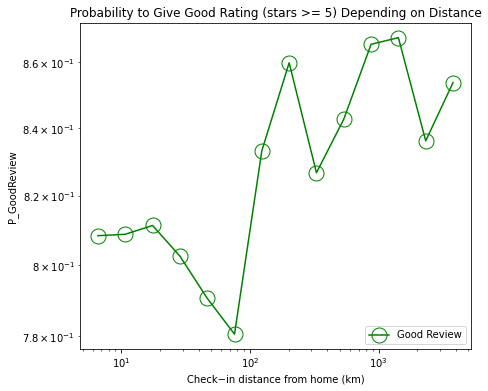

In [36]:
plt.figure(figsize=(7,6)) 
plt.plot(binsCentered,goodUserReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to Give Good Rating (stars >= 5) Depending on Distance")
#plt.ylim(0,10**2)

## Probability to go to good reviewed place

In [ ]:
df_goodPlaceReviews = df_complete[df_complete['actual_stars'] >= 5]
df_badPlaceReviews = df_complete[df_complete['actual_stars'] <= 2]

In [ ]:
goodPlaceReview = df_goodPlaceReviews['review_id'].groupby(pd.cut(df_goodPlaceReviews['distance'], bins=bins)).count()
badPlaceReview = df_badPlaceReviews['review_id'].groupby(pd.cut(df_badPlaceReviews['distance'], bins=bins)).count()

In [ ]:
#plt.figure(figsize=(7,6)) 
plt.plot(binsCentered,goodPlaceReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
#plt.plot(binsCentered,badPlaceReview/totalReview,'ro', linestyle="-", markersize=15,label='badReview')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")
#plt.ylim(10**(-2),10**(-1))

# Mean review given distance

In [ ]:
meanActualStars = df_complete[['review_id', 'actual_stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['actual_stars'].mean()
meanGivenStars = df_complete[['review_id', 'stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['stars'].mean()

In [ ]:
plt.plot(binsCentered,meanActualStars,'r*', linestyle="-", markersize=15,label='mean business stars')
plt.plot(binsCentered,meanGivenStars,'b*', linestyle="-", markersize=15,label='mean given stars')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")

#  Correction Categories

In [4]:
df_categories = pd.read_csv('name_category.csv')

In [7]:
#df_categories.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
#df_categories

In [8]:
def correction_name(x):
    name = x[0]
    name = name.replace("'", "")
    return name

def correction_category(x):
    category = x[1]
    category = category.replace(" ", "")
    category = category.replace("Consruction", "Construction")
    category = category.replace("Constructor", "Construction")
    category = category.replace("Entertainement", "Entertainment")
    category = category.replace("Entertainemnt", "Entertainment")
    category = category.replace("Entertainments", "Entertainment")
    category = category.replace("Merchants", "Merchant")
    category = category.replace("'", "")
    category = category.replace("Mischellaneous", "Miscellaneous")
    category = category.replace("food", "Food")
    return category

In [9]:
df_corrected = df_categories.copy()

In [10]:
df_corrected['name'] = df_categories.apply(lambda x: correction_name(x), axis=1)

In [11]:
df_corrected['category'] = df_categories.apply(lambda x: correction_category(x), axis=1)

In [ ]:
len(set(df_corrected['category']))

In [ ]:
df_corrected.to_csv('name_category.csv', index=False)

# Get dataframe categories

In [38]:
df_business_ori = pd.read_json("./data/yelp_academic_dataset_business.json", lines = True)

In [39]:
df_business = df_business_ori[['business_id','state','latitude','longitude', 'categories','stars', 'state']].copy()

In [40]:
df_business['categories'] = df_business.categories.apply(lambda x: [] if x == None else x.split(', '))

In [41]:
dict_categories = df_corrected.set_index('name')['category'].to_dict()

In [42]:
indexCategory = {val: key for key, val in enumerate(set(df_corrected['category']))}

In [43]:
numberCat = len(set(df_corrected['category']))
def create_category_mask(row): 
    res  = np.zeros(numberCat)
    for r in row:
        category = dict_categories.get(r)
        index = indexCategory.get(category)
        res[index] = 1
    return res > 0
           
#test_vect = np.vectorize(create_category_mask, signature='()->(k)')


In [44]:
categoryMask = df_business.apply(lambda x: create_category_mask(x.categories),axis=1)

In [45]:
for category_name in set(df_corrected['category']):
    df_business[category_name] = [tup[indexCategory.get(category_name)] for tup in categoryMask]

In [46]:
df_business.head(3)

,business_id,state,latitude,longitude,categories,stars,state,Entertainment,Merchant,Education,...,Legal,RealEstate,Construction,Manufacturing,Health,Food,Home,Miscellaneous,BusinessSupport,PersonalCare
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"[Active Life, Gun/Rifle Ranges, Guns & Ammo, S...",3.5,NC,True,True,False,...,False,False,False,False,False,False,False,False,False,True
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"[Health & Medical, Fitness & Instruction, Yoga...",5.0,AZ,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,"[Pets, Pet Services, Pet Groomers]",5.0,QC,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Observational Studies

In [22]:
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [47]:
categorySet = set(df_corrected['category'])

In [64]:
# reset of the review dataframe
df_reviews = pd.read_csv('./data/df_reviews.csv')

In [65]:
# A dataframe of the checkins made by selected users on 
df_checkinsCategory = pd.merge(df_reviews, df_selectedUsers, left_on='user_id', right_on='user_id', how='right')
df_checkinsCategory = pd.merge(df_checkinsCategory, df_business, left_on='business_id', right_on='business_id', how='inner')
df_checkinsCategory = df_checkinsCategory.rename(columns={('latitude_home', ''): "latitude_home", ('longitude_home', ''): "longitude_home"})

In [50]:
df_checkinsCategory.head(2)

,review_id,user_id,business_id,stars_x,date,friends,friend_list,review_count,state,latitude,...,Legal,RealEstate,Construction,Manufacturing,Health,Food,Home,Miscellaneous,BusinessSupport,PersonalCare
0,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...","[B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rm...",30,AZ,33.348382,...,False,False,False,False,False,False,False,False,False,True
1,5VS8E8Ys3IhQRJU3nW8YtQ,nIJD_7ZXHq-FX8byPMOkMQ,IsN0qEzgAXBjbT3qn6lokA,4,2009-02-04 17:36:27,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...","[B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rm...",30,AZ,33.527428,...,False,False,False,False,False,True,False,False,False,False


In [478]:
# A save point (can be deleted afterwards)
rollBack = df_checkinsCategory.copy()

In [388]:
treated = df_checkinsCategory[df_checkinsCategory['stars_y'] >=4].groupby('business_id').count()['review_id']
control = df_checkinsCategory[df_checkinsCategory['stars_y'] <=2].groupby('business_id').count()['review_id']

In [374]:
bins = np.geomspace(0.1, max(treated), 50)
bins[0] = 0


In [376]:
#pd.DataFrame(control)['review_id'].groupby(pd.cut(pd.DataFrame(control)['review_id'], bins=bins)).count()

In [377]:
#pd.DataFrame(treated)['review_id'].groupby(pd.cut(pd.DataFrame(treated)['review_id'], bins=bins)).count()

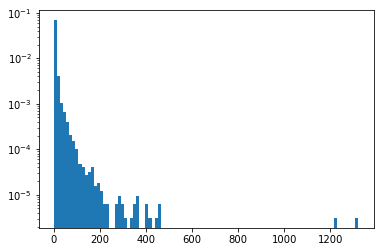

In [339]:
treatedData, binsTreated, _ = plt.hist(treated, density= True, log=True, bins=100)
binsTreatedCentered = (binsTreated[:-1] + binsTreated[1:])/2

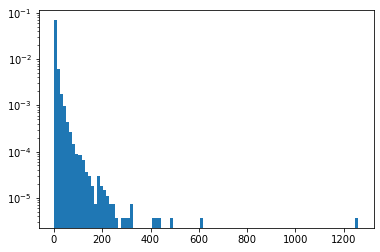

In [340]:
contorlData, controlBins, _ = plt.hist(control, density= True, log=True, bins=100)
controlBinsCentered = (controlBins[:-1] + controlBins[1:])/2

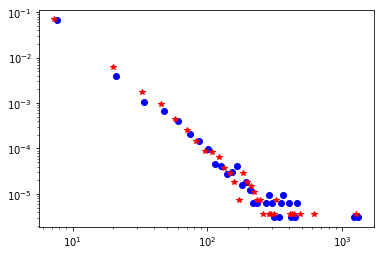

In [348]:
plt.plot(binsTreatedCentered, treatedData, 'bo')
plt.plot(controlBinsCentered, contorlData, 'r*')
plt.xscale('log')
plt.yscale('log')

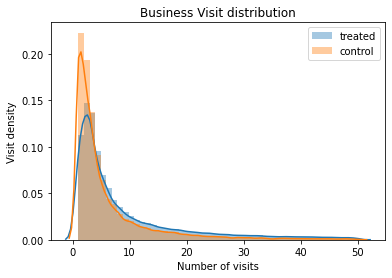

In [392]:
# income in the previous year
ax = sns.distplot(treated[treated <= 50], hist=True, label='treated');
ax = sns.distplot(control[control <= 50], hist=True, label='control')
ax.set(title='Business Visit distribution',xlabel='Number of visits', ylabel='Visit density')
plt.legend()
plt.show()

In [390]:
np.mean(treated)

27.34777793461384

In [391]:
np.mean(control)

7.594013529793346

Difference is not big => no difference ?   
To be sure, we will check the distribution of checkins among businesses

# Distribution of checkins per categories

In [452]:
# Count how buisness are distributed among categories
def count_per_category(df):
    df_res = pd.DataFrame(np.array([name for name in categorySet]),columns=['category'])
    categoryCount = np.zeros(len(categorySet))
    for category_name in categorySet:
        #print(category_name)
        categoryCount[indexCategory.get(category_name)] = df[df[category_name]].count()[0]
    df_res['count'] = categoryCount
    return df_res

In [463]:
treatedGroupSeperation = count_per_category(df_checkinsCategory[df_checkinsCategory['stars_y'] >=4])

<Figure size 720x720 with 0 Axes>

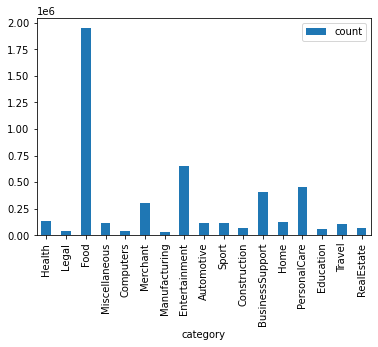

In [467]:
plt.figure(figsize=(10,10)) 
treatedGroupSeperation.plot.bar(x='category', y='count', rot=90)

In [460]:
controlGroupSeperation = count_per_category(df_checkinsCategory[df_checkinsCategory['stars_y'] <=2])

<Figure size 720x720 with 0 Axes>

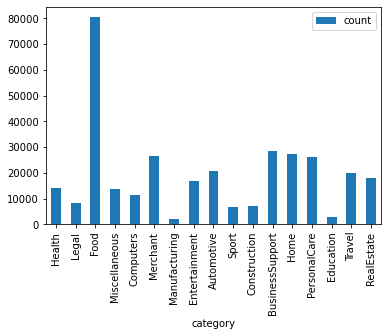

In [466]:
plt.figure(figsize=(10,10)) 
controlGroupSeperation.plot.bar(x='category', y='count', rot=90)

The treated and control group do not have the same proportion of same category => we will use propensity score between points to compare. 

# Computation of the Propensity score

In [66]:
# To compute the propensity score of checkins we will be using distance from home of the checkin
df_checkinsCategory['distance'] = df_checkinsCategory.apply(lambda x: distance.cdist([(x.latitude_home, x.longitude_home)], [(x.latitude, x.longitude)], metric=haversine)[0,0], axis=1)

In [67]:
df_checkinsCategory['normalized_distance'] = (df_checkinsCategory['distance'] - df_checkinsCategory['distance'].mean())/df_checkinsCategory['distance'].std()

In [77]:
good = df_checkinsCategory[(df_checkinsCategory['stars_y'] >= 4)]

In [78]:
bad = df_checkinsCategory[(df_checkinsCategory['stars_y'] <= 2)]

In [80]:
# Create the dataframe used for computing the propensity scores
df_prop = pd.concat([good, bad])
df_prop['treated'] = (df_prop['stars_y'] >= 4)*1

for category_name in set(df_corrected['category']):
    df_prop[category_name+'_int'] = df_prop[category_name]*1

In [95]:
mod = smf.logit(formula='treated ~ normalized_distance + C(Automotive_int) + C(BusinessSupport_int) + C(Computers_int) + C(Construction_int) + C(Education_int) + C(Entertainment_int) + C(Food_int) + C(Health_int) + C(Home_int) + C(Legal_int) + C(Manufacturing_int) + C(Merchant_int) + C(Miscellaneous_int) + C(PersonalCare_int) + C(RealEstate_int) + C(Sport_int) + C(Travel_int)', 
                data=df_prop) 

In [96]:
res = mod.fit()
# Extract the estimated propensity scores
df_prop['Propensity_score'] = res.predict()

Optimization terminated successfully.
         Current function value: 0.202507
         Iterations 8


In [102]:
rollBack = df_prop.copy()

In [106]:
df_prop.head(2)

,review_id,user_id,business_id,stars_x,date,friends,friend_list,review_count,latitude_home,longitude_home,...,RealEstate_int,Construction_int,Manufacturing_int,Health_int,Food_int,Home_int,Miscellaneous_int,BusinessSupport_int,PersonalCare_int,Propensity_score
224,0zjdJuiptDYTKGP-rZtLcg,nIJD_7ZXHq-FX8byPMOkMQ,paJaapnNsrWexFHBq18uDw,5,2014-08-10 22:00:50,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...","[B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rm...",30,33.368309,-111.810061,...,0,0,0,0,0,0,0,0,1,0.942771
225,Bc_pyVNCbmJV622Pl-0lvw,ZTfptU_YSmdE5sLg7tSYAw,paJaapnNsrWexFHBq18uDw,5,2015-05-03 16:38:10,"qZB8BZ2ZzMF0VfIGhttu7w, 0weiF2qlMMzPxXny02ZegQ...","[qZB8BZ2ZzMF0VfIGhttu7w, 0weiF2qlMMzPxXny02Zeg...",45,33.294752,-111.750092,...,0,0,0,0,0,0,0,0,1,0.942772


In [107]:
df_prop = df_prop.drop(['friends', 'friend_list'], axis=1)

In [109]:
df_prop.to_csv('df_prop.csv', index=False)

In [110]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [112]:
treatment_df = df_prop[df_prop['treated'] == 1]
control_df = df_prop[df_prop['treated'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

KeyboardInterrupt: 

In [ ]:
balanced_df_1 = df_prop.iloc[list(matching.keys())]


In [ ]:
# Separate the treatment and control groups
treatment_df_greedy = df_prop[df_prop['treated'] == 1]
control_df_greedy = df_prop[df_prop['treated'] == 0]
EPSILON = 0.05

# Create the graph instance
G_greedy = nx.Graph()

# Create a dictionary for already matched non-treated subject
# so that we can quickly check whether a non-treated subject has been matched or not
already_matched = dict()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treatment_df_greedy.iterrows():
    for control_id, control_row in control_df_greedy.iterrows():
        
        # If non-treated subject is not matched yet
        if(control_id not in already_matched.keys()):
            
            # Calculate the difference
            difference = np.abs(control_row['Propensity_score']-treatment_row['Propensity_score'])

            # add weight only if the difference less than epsilon
            if (difference < EPSILON):
                # Mark the matched id
                already_matched[control_id] = 1
                # Add to the graph
                G_greedy.add_weighted_edges_from([(control_id, treatment_id, -difference)])
                # One matching is sufficient for each treated subject
                break

# Generate and return the maximum weight matching on the generated graph
matching_greedy = nx.max_weight_matching(G=G_greedy,maxcardinality=True)

In [ ]:
df_checkinsCategory['distance'].std()

In [510]:
df_checkinsCategory[['stars_y','normalized_distance']]

,stars_y,normalized_distance
0,1.5,-0.179740
1,3.5,-0.143698
2,3.5,-0.167823
3,3.5,-0.167958
4,3.5,-0.155869
...,...,...
4516340,3.0,-0.160703
4516341,5.0,-0.191486
4516342,5.0,-0.191486
4516343,5.0,-0.191486


In [496]:
df_checkinsCategory[['stars_y', 'distance']]

,stars_y,distance
0,1.5,5.072312
1,3.5,20.636263
2,3.5,10.218474
3,3.5,10.159975
4,3.5,15.380415
...,...,...
4516340,3.0,13.292976
4516341,5.0,0.000000
4516342,5.0,0.000000
4516343,5.0,0.000000


In [ ]:
res = mod.fit()

# Extract the estimated propensity scores
df_checkinsCategory['Propensity_score'] = res.predict()

In [417]:
df = pd.DataFrame(np.array([name for name in categorySet]))


In [419]:
categoryCount = np.zeros(len(categorySet))



In [426]:
count_per_category(df_checkinsCategory[df_checkinsCategory['stars_y'] >=4])

NameError: name 'count_per_category' is not defined

In [425]:
df_checkinsCategory[df_checkinsCategory['stars_y'] >=4]

,review_id,user_id,business_id,stars_x,date,friends,friend_list,review_count,latitude_home,longitude_home,...,Entertainment,Automotive,Sport,Construction,BusinessSupport,Home,PersonalCare,Education,Travel,RealEstate
224,0zjdJuiptDYTKGP-rZtLcg,nIJD_7ZXHq-FX8byPMOkMQ,paJaapnNsrWexFHBq18uDw,5,2014-08-10 22:00:50,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...","[B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rm...",30,33.368309,-111.810061,...,False,False,False,False,False,False,True,False,False,False
225,Bc_pyVNCbmJV622Pl-0lvw,ZTfptU_YSmdE5sLg7tSYAw,paJaapnNsrWexFHBq18uDw,5,2015-05-03 16:38:10,"qZB8BZ2ZzMF0VfIGhttu7w, 0weiF2qlMMzPxXny02ZegQ...","[qZB8BZ2ZzMF0VfIGhttu7w, 0weiF2qlMMzPxXny02Zeg...",45,33.294752,-111.750092,...,False,False,False,False,False,False,True,False,False,False
226,zhQWulW6hSHbk0sHFqcOlw,-9WVpTW5LAEo9y6PbW0-cw,paJaapnNsrWexFHBq18uDw,5,2013-11-06 02:00:13,"fMRFqU1ZdjOS4bKuM4BBHg, NGqukUgODyg5qpvIyVKd4g...","[fMRFqU1ZdjOS4bKuM4BBHg, NGqukUgODyg5qpvIyVKd4...",288,33.410579,-111.911594,...,False,False,False,False,False,False,True,False,False,False
227,6ihTeW4CBzyHEAK6xij4Rg,JoT5g6CXb8CBQ_QLmKnIRA,paJaapnNsrWexFHBq18uDw,4,2015-05-16 23:23:11,"uviWU_edAcoVqCdW7TD1yQ, SO78YFzsKbao9xYY4B09wQ...","[uviWU_edAcoVqCdW7TD1yQ, SO78YFzsKbao9xYY4B09w...",244,33.392387,-111.855442,...,False,False,False,False,False,False,True,False,False,False
228,NsNkgOX6Dp7Rwh5YGaB8bQ,dIuYkwYX9zDctKN644P-Vg,paJaapnNsrWexFHBq18uDw,5,2015-08-29 00:06:26,"UClaUwwl2NEGP1wmtYeQLQ, nP1em1zqEBov4PVYMoLiqA...","[UClaUwwl2NEGP1wmtYeQLQ, nP1em1zqEBov4PVYMoLiq...",103,33.395671,-111.870085,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516335,0EKjSoW1Dd9PpZxFz0OjKw,u51f7RWvYf6n4JKyDZ-S_g,qEFXT2eVN9Un5JPekkGQNg,5,2019-09-18 12:25:41,"h7LK8tayhjvuTDjpuYb3Zg, ATnaxco-RcpdT5LVFuSocw...","[h7LK8tayhjvuTDjpuYb3Zg, ATnaxco-RcpdT5LVFuSoc...",4,35.147425,-80.829315,...,False,False,False,False,False,False,True,False,False,False
4516341,wMiYcPbtTV6yMHQgS1AsTQ,-2e5_Rlby0zx5OfG7B7zsg,rDzSaJ0AaFmrDATauMnUGQ,5,2017-05-15 02:36:59,"cXsmsTEigCZCREKDGstHnw, dgXfFMzlJ_WDUGkpEXYCJg...","[cXsmsTEigCZCREKDGstHnw, dgXfFMzlJ_WDUGkpEXYCJ...",3,33.524364,-111.898592,...,False,False,False,False,False,True,False,False,False,False
4516342,fnw_ZAytnQL5kn6iYzglvA,ksHreH7-pdNQhO28bJsQjA,ItZ0dvwbWL7_e_QYNXRhUA,4,2015-12-07 19:09:50,"zpMvXReWlU4sKjY8mNW_QQ, CONCLr2u6RC89jtankSFhA...","[zpMvXReWlU4sKjY8mNW_QQ, CONCLr2u6RC89jtankSFh...",3,33.554300,-111.893166,...,False,False,False,False,False,False,True,False,False,False
4516343,7wJ1nOoGhbotO7Z8FUoiFQ,ksHreH7-pdNQhO28bJsQjA,ItZ0dvwbWL7_e_QYNXRhUA,5,2015-05-20 16:46:52,"zpMvXReWlU4sKjY8mNW_QQ, CONCLr2u6RC89jtankSFhA...","[zpMvXReWlU4sKjY8mNW_QQ, CONCLr2u6RC89jtankSFh...",3,33.554300,-111.893166,...,False,False,False,False,False,False,True,False,False,False
